# CASTEP Al Slab benchmark performance

This notebook compares the performance of the small Al Slab (al3x3) benchmark across different HPC facilities.

We compute the mean time per SCF cycle from all cycles in the output file apart from the fastest and slowest cycle times. Performance is plotted as SCF cycles per second.

## Setup section

Import the required modules and define useful functions.

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [9]:
import sys
sys.path.append('../../../python-modules')

In [10]:
from utilities import filemanip, sysinfo
from appanalysis import castep

In [11]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [12]:
systems = ['ARCHER','Athena','Cirrus','Thomas','Tesseract','CSD3-Skylake','Isambard','EPCC-CascadeLake']
perf = {}
notes = {}
names = {}
nodes = {}
perf_max = {}
cpn = {}

for system in systems:
    wdir = '../al3x3/results/' + system
    filelist = filemanip.get_filelist(wdir, 'al3x3_')
    sysdict = sysdetails[system]
    names[system] = sysdict['Name']
    cpn[system] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(sysdict['Name'])
    castep_df = pd.DataFrame(castep.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes[system], perf_max[system] = castep.get_perf_stats(castep_df, 'max', writestats=True)
    print('\n============================================================')


ARCHER
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     24     0.005409  0.005429  0.005519  0.005453     5
2     48     0.011341  0.011341  0.011341  0.011341     1
4     96     0.019480  0.019480  0.019480  0.019480     1
8     192    0.030145  0.030145  0.030145  0.030145     1
16    384    0.034719  0.034719  0.034719  0.034719     1


Athena
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     28     0.009842  0.009918  0.009946  0.009904     6
2     56     0.020530  0.020530  0.020530  0.020530     1
4     112    0.024945  0.032045  0.039145  0.032045     2
8     224    0.065784  0.065784  0.065784  0.065784     1
16    448    0.053135  0.061107  0.069079  0.061107     2


Cirrus
                 Perf                         

## Performance Comparison

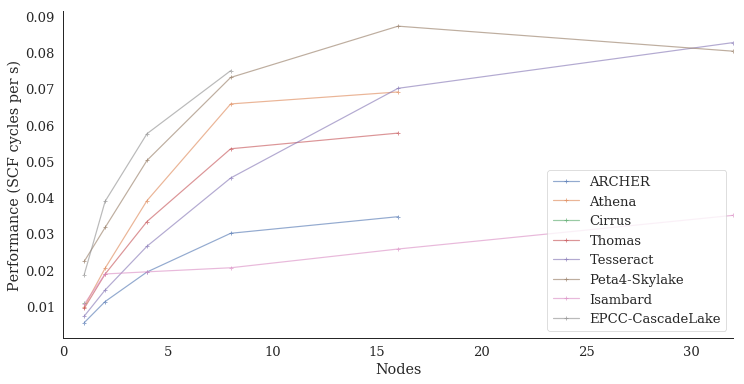

In [13]:
for system in systems:
    plt.plot(nodes[system], perf_max[system], '-+', label=names[system], alpha=0.6)
plt.xlim((0,32))
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## Single node performance comparisons

In [14]:
n_baseperf = perf_max['ARCHER'][0]
c_baseperf = perf_max['ARCHER'][0]/cpn['ARCHER']

print("Performance improvement relative to ARCHER:\n")
print("{:>30s} {:>20s} {:>15s}".format('System', 'Perf (SCF cycles/s)', 'Improvement'))
print("{:>30s} {:>20s} {:>15s}".format('======', '===================', '==========='))
print("Single node")
for system in systems:
    print("{:>30s} {:>20.5f} {:>15.3f}".format(system, perf_max[system][0], perf_max[system][0]/n_baseperf))
    
print("\n")

print("per-core")
for system in systems:
    cperf = perf_max[system][0]/cpn[system]
    print("{:>30s} {:>20.5f} {:>15.3f}".format(system, cperf, cperf/c_baseperf))

Performance improvement relative to ARCHER:

                        System  Perf (SCF cycles/s)     Improvement
                        ======  ===================     ===========
Single node
                        ARCHER              0.00552           1.000
                        Athena              0.00995           1.802
                        Cirrus              0.01086           1.969
                        Thomas              0.00946           1.714
                     Tesseract              0.00731           1.324
                  CSD3-Skylake              0.02240           4.058
                      Isambard              0.01063           1.926
              EPCC-CascadeLake              0.01876           3.398


per-core
                        ARCHER              0.00023           1.000
                        Athena              0.00036           1.545
                        Cirrus              0.00030           1.312
                        Thomas              0.00